In [13]:
# 레티나 디스플레이로 폰트가 선명하게 표시되도록 합니다.
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# 라이브러리를 로드합니다.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from collections import Counter
from konlpy.tag import Okt
import re


# 한글폰트를 설정합니다.
plt.rc('font',family='AppleGothic')
plt.rc('axes',unicode_minus=False)

<Figure size 800x600 with 0 Axes>

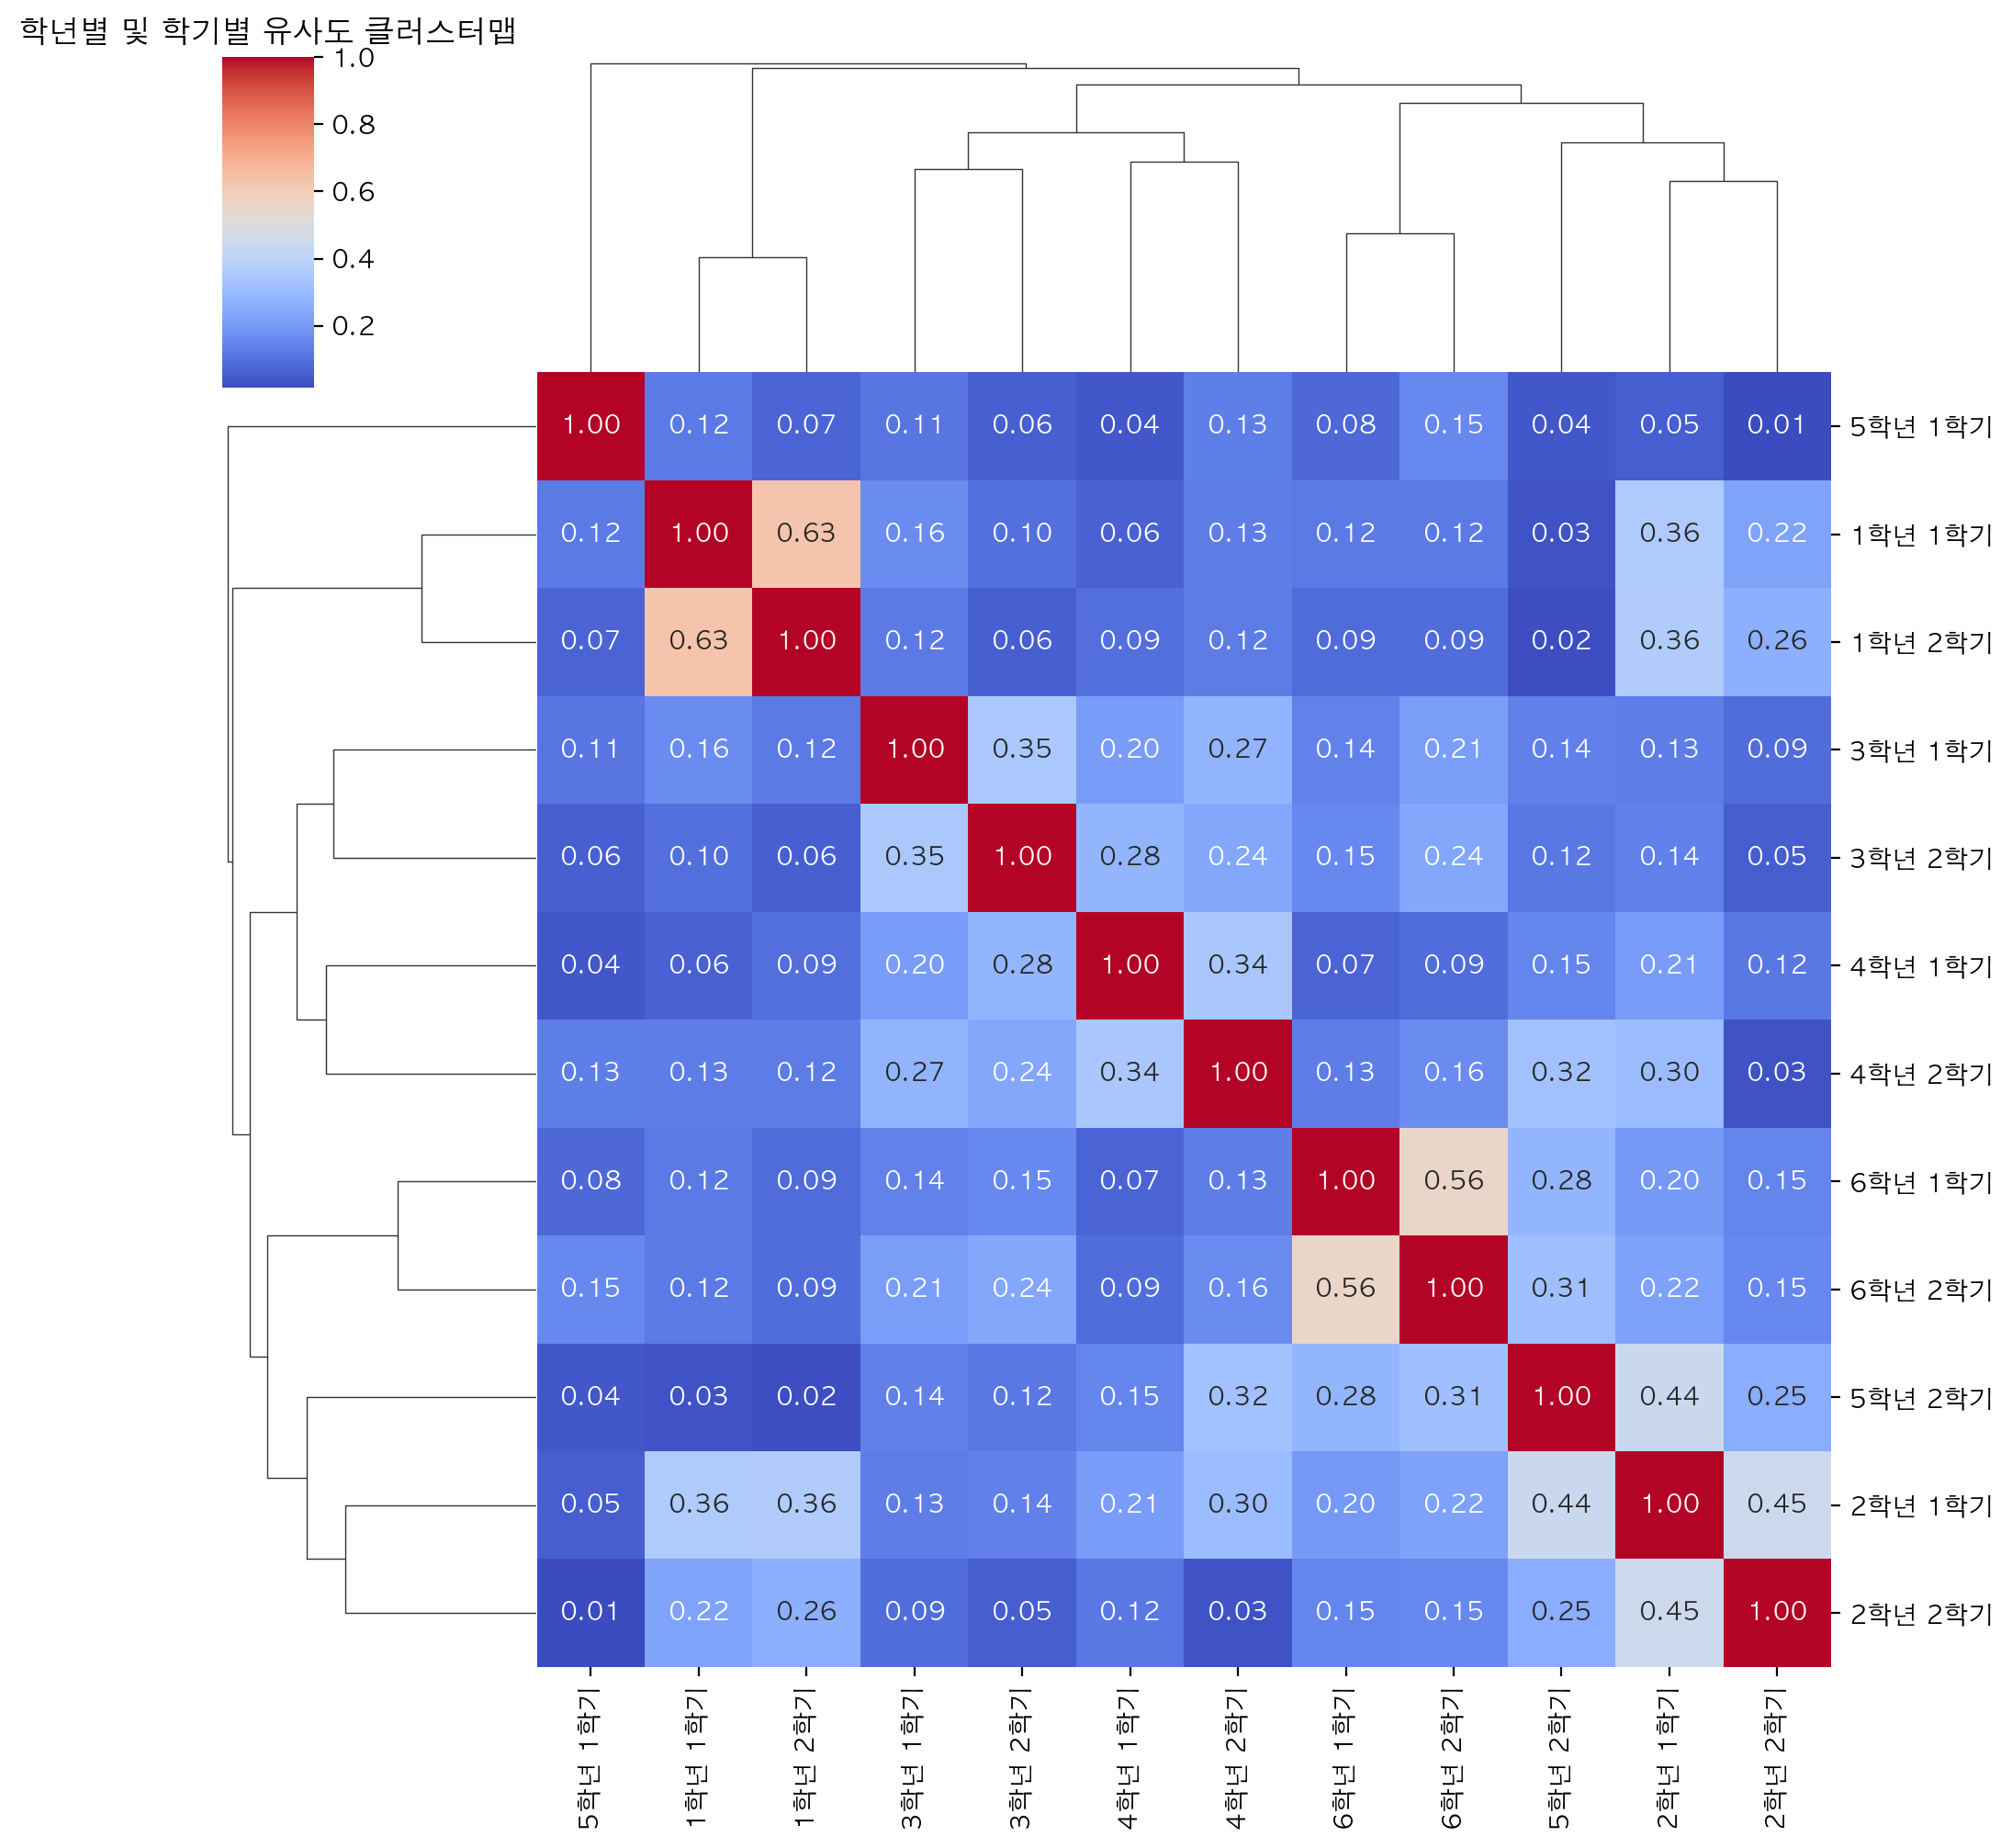

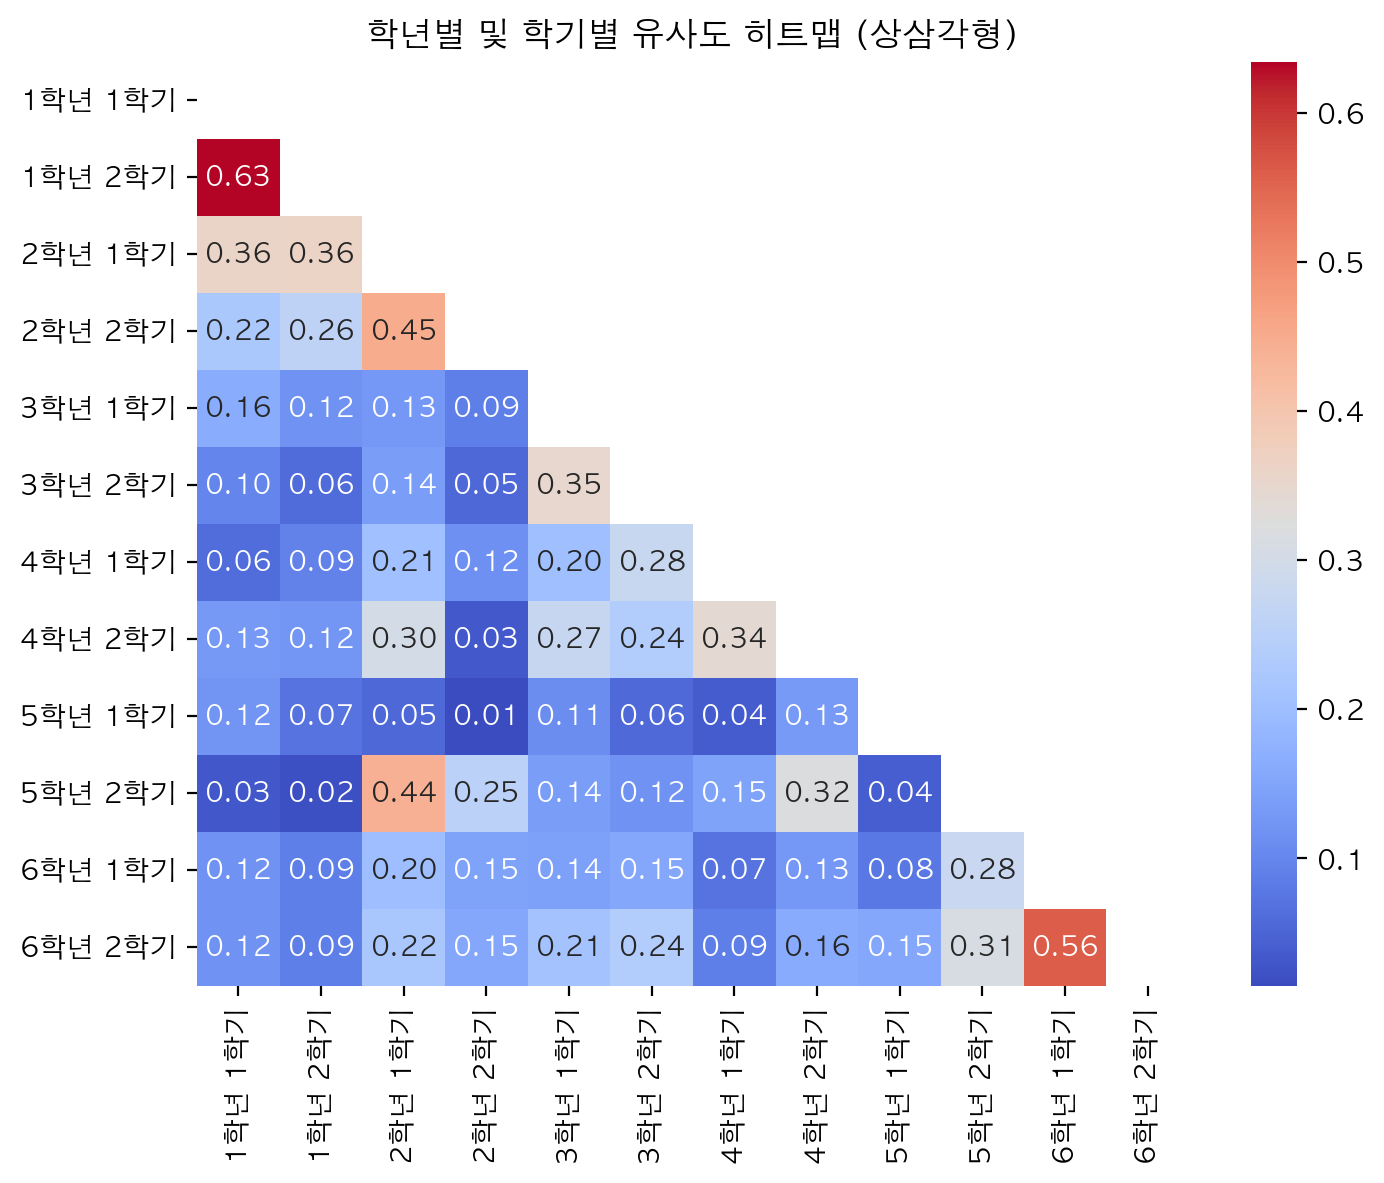

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# tf-idf.csv 파일 불러오기
data = pd.read_csv('tf-idf.csv')

# 결측치(NaN)를 빈 문자열로 대체
data.fillna('', inplace=True)

# 강의 데이터를 결합 (학년, 학기, 강의 제목, 수업내용, 키워드)
data['combined_text'] = data['강의 제목'] + ' ' + data['수업내용'] + ' ' + data['키워드']

# 학년별 및 학기별로 그룹화하여 텍스트 결합
data_grouped = data.groupby(['학년', '학기'])['combined_text'].apply(lambda x: ' '.join(x)).reset_index()

# TF-IDF 벡터라이저 생성 및 학습
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data_grouped['combined_text'])

# 코사인 유사도를 사용하여 학년별 및 학기별 유사도 계산
cosine_similarities = cosine_similarity(tfidf_matrix)

# 유사도 행렬을 데이터프레임으로 변환 (학년과 학기를 인덱스 및 컬럼으로 사용)
similarity_df = pd.DataFrame(cosine_similarities, 
                             index=data_grouped['학년'] + ' ' + data_grouped['학기'], 
                             columns=data_grouped['학년'] + ' ' + data_grouped['학기'])

### 1. 클러스터맵 시각화
plt.figure(figsize=(8, 6))
sns.clustermap(similarity_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('학년별 및 학기별 유사도 클러스터맵')
plt.show()

### 2. 히트맵 상삼각형(절반) 시각화
plt.figure(figsize=(8, 6))

# 상삼각형 마스크 생성
mask = np.triu(np.ones_like(similarity_df, dtype=bool))

# 히트맵 그리기 (마스크 적용)
sns.heatmap(similarity_df, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('학년별 및 학기별 유사도 히트맵 (상삼각형)')
plt.show()

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_75709/3691119514.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='학년', y='평균 유사도', data=similarity_df, palette=bar_colors)
/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_75709/3691119514.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(tick * 10)}%' for tick in ax.get_yticks()])


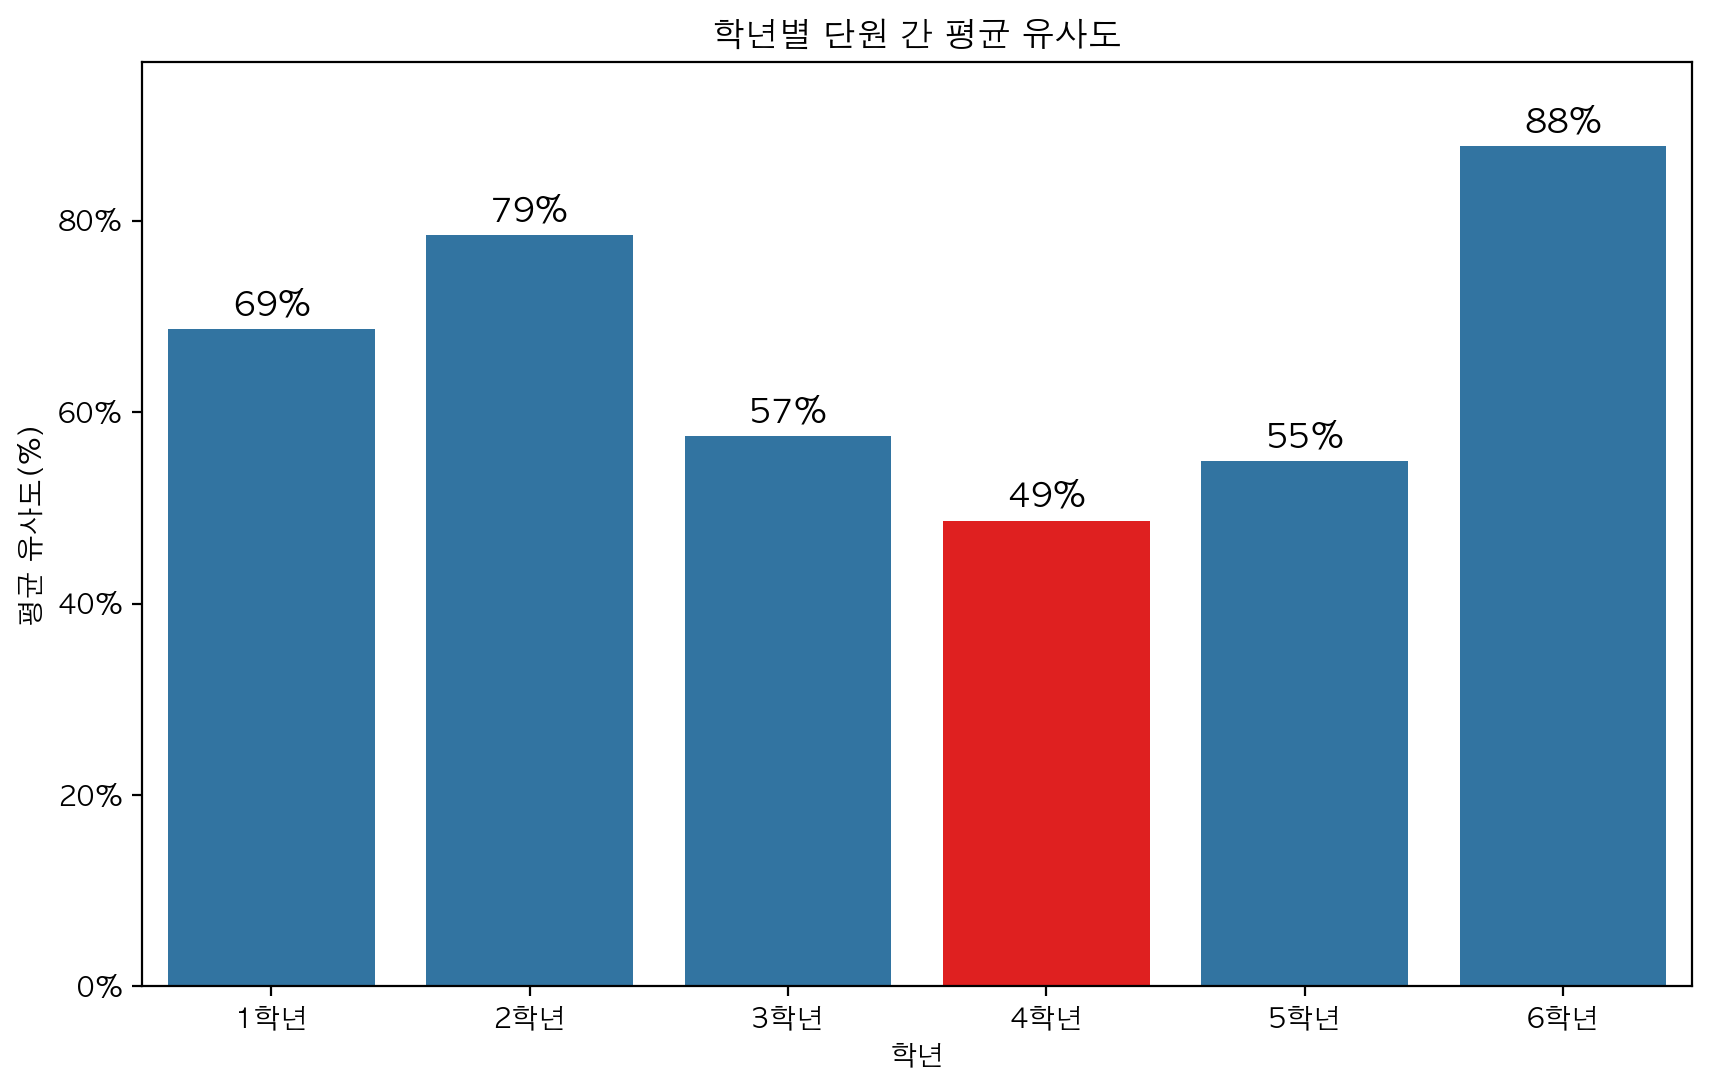

In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
data = pd.read_csv('tf-idf.csv')

# 결측치(NaN)를 빈 문자열로 대체
data.fillna('', inplace=True)

# 강의 데이터를 결합 (강의 제목 + 수업내용 + 키워드)
data['combined_text'] = data['강의 제목'] + ' ' + data['수업내용'] + ' ' + data['키워드']

# 학년 리스트 생성
grades = data['학년'].unique()

# 학년별 유사도 평균을 저장할 리스트
grade_similarity_means = []

# 학년별로 유사도 계산
for grade in grades:
    # 학년별 데이터 필터링
    grade_data = data[data['학년'] == grade]
    
    # TF-IDF 벡터라이저 생성 및 학습
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(grade_data['combined_text'])
    
    # 코사인 유사도 계산
    cosine_similarities = cosine_similarity(tfidf_matrix)
    
    # 유사도 행렬에서 자기 자신과의 유사도를 제외한 값들을 사용하여 평균 계산
    np.fill_diagonal(cosine_similarities, np.nan)  # 자기 자신과의 유사도를 제외
    mean_similarity = np.nanmean(cosine_similarities)  # 유사도 평균 계산
    
    # 학년별 평균 유사도를 리스트에 추가
    grade_similarity_means.append(mean_similarity * 100)

# 학년별 평균 유사도를 데이터프레임으로 저장
similarity_df = pd.DataFrame({
    '학년': grades,
    '평균 유사도': grade_similarity_means
})

# 최소 유사도를 가진 학년 찾기
min_similarity = similarity_df['평균 유사도'].min()  # 최소 유사도
highlight_color = 'red'  # 강조할 색상

# 학년별로 바의 색상 설정 (최소값인 학년만 빨간색으로 강조, 나머지는 기본 색상 사용)
bar_colors = ['red' if val == min_similarity else 'C0' for val in similarity_df['평균 유사도']]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='학년', y='평균 유사도', data=similarity_df, palette=bar_colors)

# 수치를 바 상단에 기본값 그대로 표시
for p in ax.patches:
    percentage = p.get_height() * 10
    ax.annotate(f'{percentage:.0f}%',  # 소수점 2자리 유지
                (p.get_x() + p.get_width() / 2., p.get_height()),  # 위치 설정
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# 그래프 제목 및 축 레이블 설정
# Y축을 퍼센트로 변환
ax.set_ylim(0, max(similarity_df['평균 유사도']) * 1.1)  # 상단에 여백을 약간 추가
ax.set_yticklabels([f'{int(tick * 10)}%' for tick in ax.get_yticks()])

plt.title("학년별 단원 간 평균 유사도")
plt.xlabel("학년")
plt.ylabel("평균 유사도(%)")
plt.show()



In [16]:
print(similarity_df.to_string(index=False))

 학년   평균 유사도
1학년 0.068693
2학년 0.078506
3학년 0.057472
4학년 0.048660
5학년 0.054879
6학년 0.087747


In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
data = pd.read_csv('tf-idf.csv')

# 결측치(NaN)를 빈 문자열로 대체
data.fillna('', inplace=True)

# 강의 데이터를 결합 (강의 제목 + 수업내용 + 키워드)
data['combined_text'] = data['강의 제목'] + ' ' + data['수업내용'] + ' ' + data['키워드']

# 학년 리스트 생성
grades = data['학년'].unique()

data[['학년','combined_text']]

,학년,combined_text
0,1학년,"01강 1. 9까지의 수(1)_Book1 1, 2, 3, 4, 5를 읽고 쓰기 1,..."
1,1학년,"02강 1. 9까지의 수(2)_Book1 6, 7, 8, 9를 읽고 쓰기 6, 7,..."
2,1학년,03강 1. 9까지의 수(3)_Book1 수로 순서를 나타내기 / 수의 순서를 알아...
3,1학년,"04강 1. 9까지의 수(4)_Book1 0 알아보기 / 수의 크기 비교하기 0, ..."
4,1학년,05강 1. 9까지의 수(5)_Book1 확인 평가를 통해 단원 학습 내용을 확인해...
...,...,...
347,6학년,"29강 원의 넓이 (4) 개념 확인 학습 (6)\n원의 넓이를 활용하기 원의 넓이,..."
348,6학년,"30강 원의 넓이 (5) 단원 확인 평가 원주, 지름, 원주율, 원의 넓이, 활용"
349,6학년,"31강 원기둥, 원뿔, 구 (1) 개념 확인 학습 (1), (2)\n원기둥 알아보기..."
350,6학년,"32강 원기둥, 원뿔, 구 (2) 개념 확인 학습 (3), (4)\n원뿔 알아보기,..."


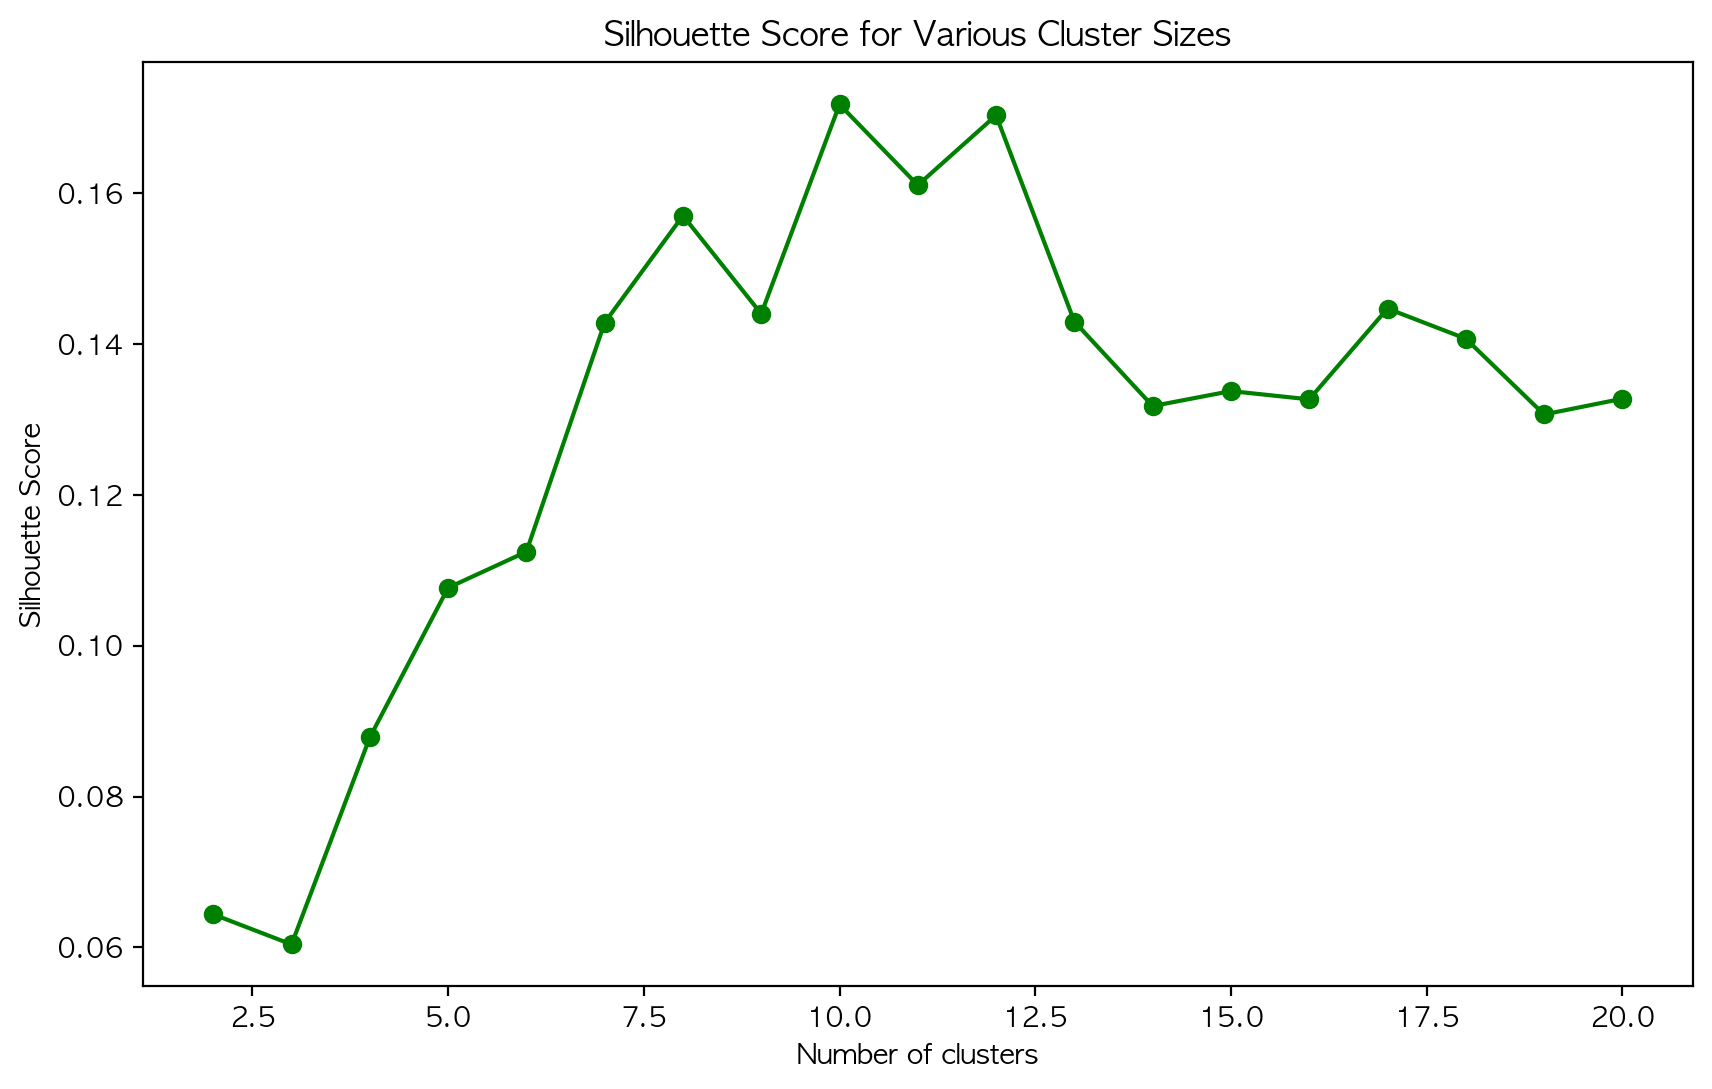

In [18]:
from sklearn.metrics import silhouette_score

# 클러스터 수에 따른 Silhouette Score 계산
silhouette_scores = []
for i in range(2, 21):  # 클러스터 개수를 2~20까지 변화시키면서 Silhouette Score 확인
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(score)

# Silhouette Score를 시각화하여 최적의 클러스터 수를 확인
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score for Various Cluster Sizes')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()